# EE 413 - Image Compression and Classification with Deep Learning

## Team Members
- **Mohammed**: Model Selection and Baseline Establishment
- **Saud**: Wavelet-based Image Compression
- **Naif**: Fine-tuning on Compressed Data
- **Osama**: Compressed Sensing Experiment

## 0. Importing Libraries

In [49]:
import os
#os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE" #I have OpenMP Conflict and this line resolves it
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import time
from tqdm.notebook import tqdm  # works great in Colab

import shutil
from sklearn.model_selection import train_test_split
from torchvision import datasets, models, transforms
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Model Selection and Baseline Establishment (Mohammed)
### 1.1 Select two pre-trained models
For our Mini-ImageNet classification task, we selected ResNet50 and VGG16, two widely adopted convolutional neural network architectures from the PyTorch models.

- ResNet50:

A deep residual network with 50 layers that utilizes skip connections to address the vanishing gradient problem, enabling deeper and more accurate models.

- VGG16:

A simpler, uniform architecture consisting of 16 layers with small (3×3) filters.

### 1.2 Load Mini-ImageNet dataset
- Resizing and splitting into train/test.

### 1.3 Modify and Fine-tune models
- Resize to fit model requirements (e.g., 96x96)
- Adjust classifier layer

### 1.4 Evaluate baseline performance
_Report accuracy, confusion matrix, etc._

In [37]:
#Parameters
IMG_SIZE = 96
BATCH_SIZE = 128
NUM_CLASSES = 100
NUM_EPOCHS = 12
LEARNING_RATE = 0.01
VAL_RATIO = 0.2

# Transforms (Resize and Normalize)
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])  #Those values are selected based on PyTorch documentation
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

#Pytorch Documentation: the values are first rescaled to [0.0, 1.0] and then normalized using mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].

Using device: cuda


In [38]:
#1.2
# Load and prepare Mini-ImageNet

full_dataset = datasets.ImageFolder('/content/train', transform=transform)
val_size = int(VAL_RATIO * len(full_dataset))
train_size = len(full_dataset) - val_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [39]:
#1.3
# Load pre-trained models and modify for classification

def get_model(name):
    if name == "resnet50":
        model = models.resnet50(weights="IMAGENET1K_V2")
        model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
    elif name == "vgg16":
        model = models.vgg16(weights='IMAGENET1K_V1')
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, NUM_CLASSES)
    return model

# Training Function
def train_model(model, optimizer, criterion):
    #########################
    since = time.time()
    best_acc = 0.0

    for epoch in range(NUM_EPOCHS):
        print(f'Epoch {epoch}/{NUM_EPOCHS - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                data_loader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                data_loader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(data_loader, desc=f"{phase} Epoch {epoch+1}/{NUM_EPOCHS}", leave=False):

                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(data_loader.dataset)
            epoch_acc = running_corrects.double() / len(data_loader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
        print()
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    #########################

# Evaluation Function
def evaluate_model(model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Accuracy: {100 * correct / total:.2f}%")

# Run for ResNet50
model_resnet = get_model("resnet50").to(device)
optimizer_resnet = torch.optim.SGD(model_resnet.parameters(),lr=LEARNING_RATE,momentum=0.9,)
criterion = nn.CrossEntropyLoss()

print("Training ResNet50...")
train_model(model_resnet, optimizer_resnet, criterion)
evaluate_model(model_resnet)

# Run for VGG16
model_vgg = get_model("vgg16").to(device)
optimizer_vgg = torch.optim.SGD(model_vgg.parameters(), lr=LEARNING_RATE, momentum=0.9)

print("\nTraining VGG16...")
train_model(model_vgg, optimizer_vgg, criterion)
evaluate_model(model_vgg)

Training ResNet50...
Epoch 0/11
----------


train Epoch 1/12:   0%|          | 0/375 [00:00<?, ?it/s]

train Loss: 0.9589 Acc: 0.7630


val Epoch 1/12:   0%|          | 0/94 [00:00<?, ?it/s]

val Loss: 0.5898 Acc: 0.8329

Epoch 1/11
----------


train Epoch 2/12:   0%|          | 0/375 [00:00<?, ?it/s]

train Loss: 0.2985 Acc: 0.9134


val Epoch 2/12:   0%|          | 0/94 [00:00<?, ?it/s]

val Loss: 0.6067 Acc: 0.8352

Epoch 2/11
----------


train Epoch 3/12:   0%|          | 0/375 [00:00<?, ?it/s]

train Loss: 0.1111 Acc: 0.9687


val Epoch 3/12:   0%|          | 0/94 [00:00<?, ?it/s]

val Loss: 0.6225 Acc: 0.8438

Epoch 3/11
----------


train Epoch 4/12:   0%|          | 0/375 [00:00<?, ?it/s]

train Loss: 0.0431 Acc: 0.9890


val Epoch 4/12:   0%|          | 0/94 [00:00<?, ?it/s]

val Loss: 0.6374 Acc: 0.8484

Epoch 4/11
----------


train Epoch 5/12:   0%|          | 0/375 [00:00<?, ?it/s]

train Loss: 0.0199 Acc: 0.9959


val Epoch 5/12:   0%|          | 0/94 [00:00<?, ?it/s]

val Loss: 0.6396 Acc: 0.8537

Epoch 5/11
----------


train Epoch 6/12:   0%|          | 0/375 [00:00<?, ?it/s]

train Loss: 0.0092 Acc: 0.9986


val Epoch 6/12:   0%|          | 0/94 [00:00<?, ?it/s]

val Loss: 0.6439 Acc: 0.8564

Epoch 6/11
----------


train Epoch 7/12:   0%|          | 0/375 [00:00<?, ?it/s]

train Loss: 0.0067 Acc: 0.9987


val Epoch 7/12:   0%|          | 0/94 [00:00<?, ?it/s]

val Loss: 0.6680 Acc: 0.8554

Epoch 7/11
----------


train Epoch 8/12:   0%|          | 0/375 [00:00<?, ?it/s]

train Loss: 0.0057 Acc: 0.9989


val Epoch 8/12:   0%|          | 0/94 [00:00<?, ?it/s]

val Loss: 0.6765 Acc: 0.8581

Epoch 8/11
----------


train Epoch 9/12:   0%|          | 0/375 [00:00<?, ?it/s]

train Loss: 0.0044 Acc: 0.9991


val Epoch 9/12:   0%|          | 0/94 [00:00<?, ?it/s]

val Loss: 0.6771 Acc: 0.8562

Epoch 9/11
----------


train Epoch 10/12:   0%|          | 0/375 [00:00<?, ?it/s]

train Loss: 0.0035 Acc: 0.9993


val Epoch 10/12:   0%|          | 0/94 [00:00<?, ?it/s]

val Loss: 0.6929 Acc: 0.8553

Epoch 10/11
----------


train Epoch 11/12:   0%|          | 0/375 [00:00<?, ?it/s]

train Loss: 0.0037 Acc: 0.9992


val Epoch 11/12:   0%|          | 0/94 [00:00<?, ?it/s]

val Loss: 0.7009 Acc: 0.8573

Epoch 11/11
----------


train Epoch 12/12:   0%|          | 0/375 [00:00<?, ?it/s]

train Loss: 0.0029 Acc: 0.9995


val Epoch 12/12:   0%|          | 0/94 [00:00<?, ?it/s]

val Loss: 0.6963 Acc: 0.8594

Training complete in 4m 0s
Accuracy: 85.94%

Training VGG16...
Epoch 0/11
----------


train Epoch 1/12:   0%|          | 0/375 [00:00<?, ?it/s]

train Loss: 1.7646 Acc: 0.5515


val Epoch 1/12:   0%|          | 0/94 [00:00<?, ?it/s]

val Loss: 1.2568 Acc: 0.6567

Epoch 1/11
----------


train Epoch 2/12:   0%|          | 0/375 [00:00<?, ?it/s]

train Loss: 1.0695 Acc: 0.7035


val Epoch 2/12:   0%|          | 0/94 [00:00<?, ?it/s]

val Loss: 1.1522 Acc: 0.6867

Epoch 2/11
----------


train Epoch 3/12:   0%|          | 0/375 [00:00<?, ?it/s]

train Loss: 0.7718 Acc: 0.7812


val Epoch 3/12:   0%|          | 0/94 [00:00<?, ?it/s]

val Loss: 1.1467 Acc: 0.6911

Epoch 3/11
----------


train Epoch 4/12:   0%|          | 0/375 [00:00<?, ?it/s]

train Loss: 0.5712 Acc: 0.8311


val Epoch 4/12:   0%|          | 0/94 [00:00<?, ?it/s]

val Loss: 1.1183 Acc: 0.7084

Epoch 4/11
----------


train Epoch 5/12:   0%|          | 0/375 [00:00<?, ?it/s]

train Loss: 0.4473 Acc: 0.8661


val Epoch 5/12:   0%|          | 0/94 [00:00<?, ?it/s]

val Loss: 1.1902 Acc: 0.7077

Epoch 5/11
----------


train Epoch 6/12:   0%|          | 0/375 [00:00<?, ?it/s]

train Loss: 0.3476 Acc: 0.8935


val Epoch 6/12:   0%|          | 0/94 [00:00<?, ?it/s]

val Loss: 1.2404 Acc: 0.7034

Epoch 6/11
----------


train Epoch 7/12:   0%|          | 0/375 [00:00<?, ?it/s]

train Loss: 0.2804 Acc: 0.9139


val Epoch 7/12:   0%|          | 0/94 [00:00<?, ?it/s]

val Loss: 1.3388 Acc: 0.6947

Epoch 7/11
----------


train Epoch 8/12:   0%|          | 0/375 [00:00<?, ?it/s]

train Loss: 0.2241 Acc: 0.9298


val Epoch 8/12:   0%|          | 0/94 [00:00<?, ?it/s]

val Loss: 1.3236 Acc: 0.7082

Epoch 8/11
----------


train Epoch 9/12:   0%|          | 0/375 [00:00<?, ?it/s]

train Loss: 0.2102 Acc: 0.9350


val Epoch 9/12:   0%|          | 0/94 [00:00<?, ?it/s]

val Loss: 1.3748 Acc: 0.6971

Epoch 9/11
----------


train Epoch 10/12:   0%|          | 0/375 [00:00<?, ?it/s]

train Loss: 0.1895 Acc: 0.9418


val Epoch 10/12:   0%|          | 0/94 [00:00<?, ?it/s]

val Loss: 1.4567 Acc: 0.6976

Epoch 10/11
----------


train Epoch 11/12:   0%|          | 0/375 [00:00<?, ?it/s]

train Loss: 0.1446 Acc: 0.9550


val Epoch 11/12:   0%|          | 0/94 [00:00<?, ?it/s]

val Loss: 1.5012 Acc: 0.7023

Epoch 11/11
----------


train Epoch 12/12:   0%|          | 0/375 [00:00<?, ?it/s]

train Loss: 0.1405 Acc: 0.9569


val Epoch 12/12:   0%|          | 0/94 [00:00<?, ?it/s]

val Loss: 1.4814 Acc: 0.7029

Training complete in 5m 1s
Accuracy: 70.29%


In [41]:

PATH = 'content/res_net.pth'
torch.save(model_resnet.state_dict(), PATH)

PATH = 'content/vgg_net.pth'
torch.save(model_vgg.state_dict(), PATH)


In [43]:
# Load
NUM_CLASSES = 100  # adjust as needed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_resnet = models.resnet50(weights=None)  # No pretrained weights since we're loading ours
model_resnet.fc = nn.Linear(model_resnet.fc.in_features, NUM_CLASSES)

PATH = '/content/res_net.pth'
model_resnet.load_state_dict(torch.load(PATH, map_location=device))
model_resnet = model_resnet.to(device)
model_resnet.eval()

model_vgg = models.vgg16(weights=None)
model_vgg.classifier[6] = nn.Linear(model_vgg.classifier[6].in_features, NUM_CLASSES)

PATH = '/content/vgg_net.pth'
model_vgg.load_state_dict(torch.load(PATH, map_location=device))
model_vgg = model_vgg.to(device)
model_vgg.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [57]:
dict_mapping = {i: class_name for i, class_name in enumerate(val_dataset.dataset.classes)}

In [61]:
def evaluate_performance(model, dataloader, class_mapping, device, model_name="Model"):
    """
    Evaluates a trained CNN model on a dataloader and prints accuracy,
    confusion matrix, and classification report.

    Args:
        model: Trained PyTorch model
        dataloader: DataLoader for validation or test set (shuffle=False)
        class_mapping: dict {int: class_name}
        device: torch.device("cuda" or "cpu")
    """

    model.eval()
    model.to(device)

    all_preds = []
    all_labels = []
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = 100 * correct / total
    print(f"\Accuracy on test set: {acc:.2f}%")
    print("--------------------------------------------------")

    class_names = [class_mapping[i] for i in sorted(class_mapping.keys())]
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    print("Confusion Matrix:")
    plot_confusion_matrix(all_labels, all_preds, class_names=class_mapping.values(),Model_Name=model_name, save_path=model_name+'_Confusion_Matrix')

In [59]:
def plot_confusion_matrix(y_true, y_pred, class_names, Model_Name, figsize=(20, 20), save_path=None):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=class_names, yticklabels=class_names, cbar=True)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix "+Model_Name)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

\Accuracy on test set: 85.94%
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

   n01532829       0.94      0.89      0.91       132
   n01558993       0.91      0.88      0.89       120
   n01704323       0.92      0.97      0.95       125
   n01749939       0.92      0.95      0.94       122
   n01770081       0.88      0.91      0.89        98
   n01843383       0.93      0.93      0.93       107
   n01855672       0.93      0.88      0.91       112
   n01910747       0.92      0.96      0.94       114
   n01930112       0.95      0.93      0.94       116
   n01981276       0.94      0.90      0.92       109
   n02074367       0.96      0.98      0.97       118
   n02089867       0.82      0.82      0.82       114
   n02091244       0.82      0.87      0.84       107
   n02091831       0.81      0.74      0.77       127
   n02099601       0.83      0.87      0.85       120
   n02101006       0.77      0.

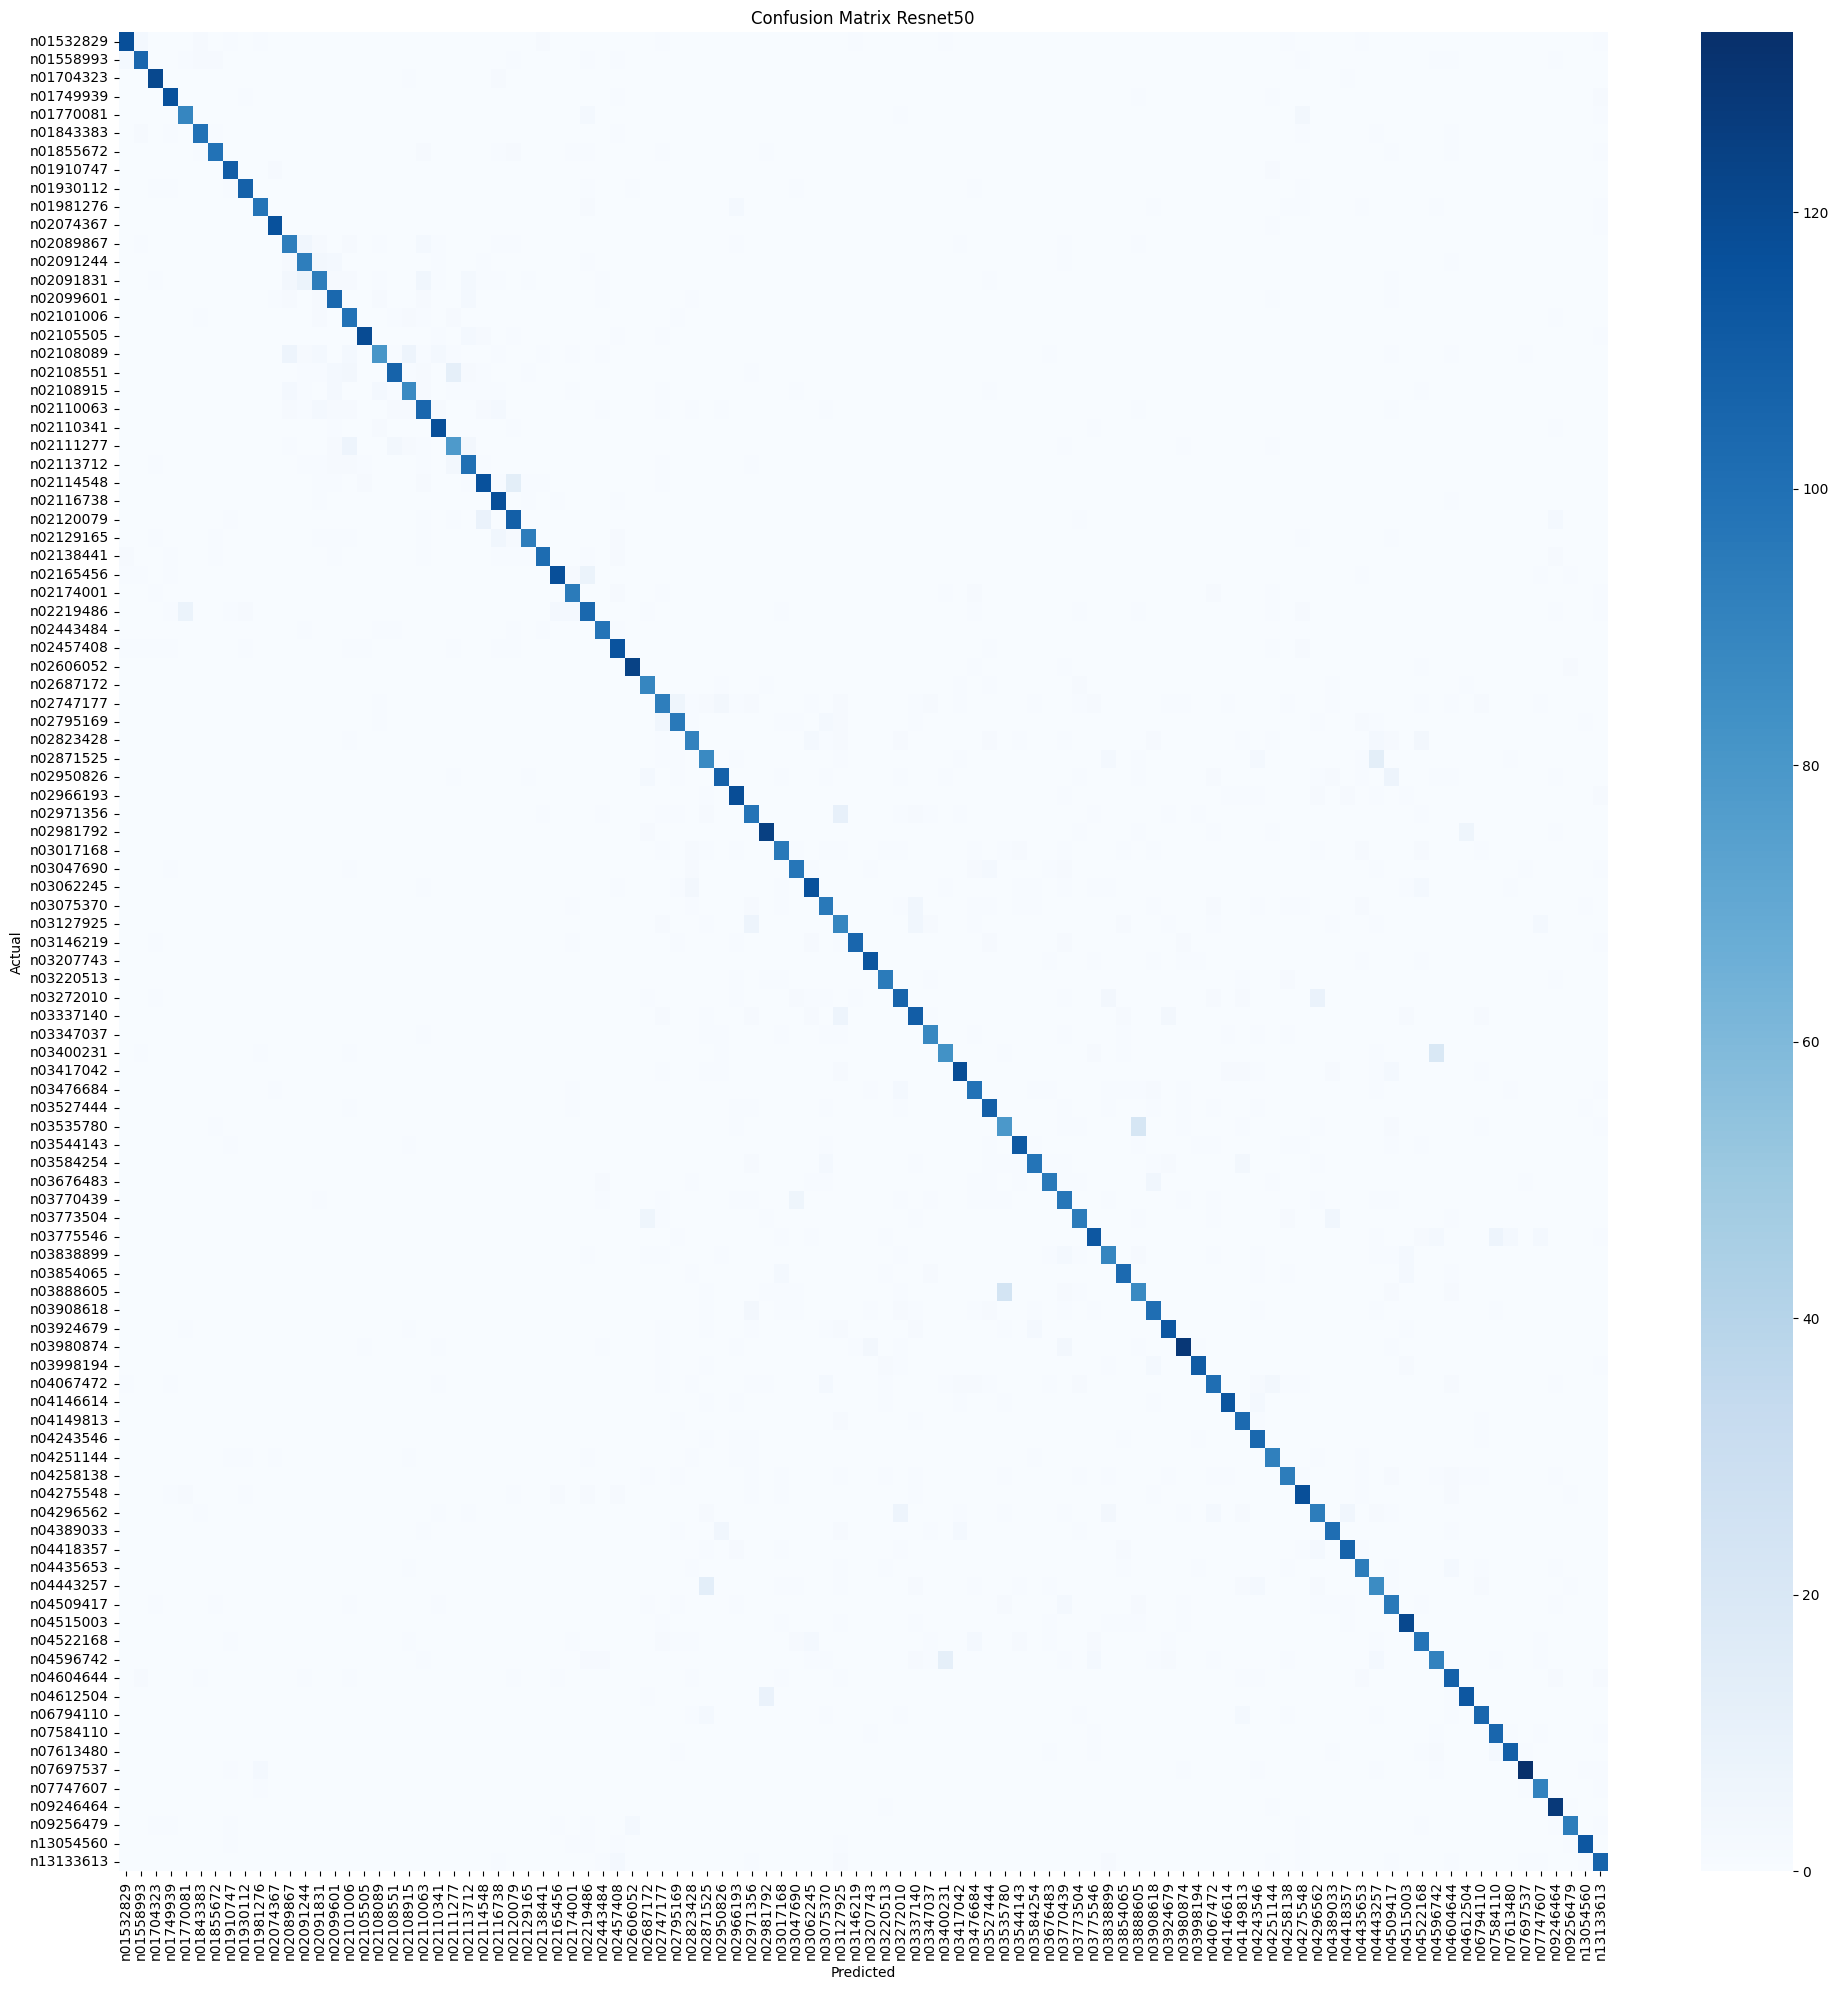

\Accuracy on test set: 70.29%
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

   n01532829       0.81      0.79      0.80       132
   n01558993       0.89      0.82      0.86       120
   n01704323       0.71      0.82      0.76       125
   n01749939       0.86      0.80      0.83       122
   n01770081       0.73      0.77      0.75        98
   n01843383       0.79      0.85      0.82       107
   n01855672       0.66      0.84      0.74       112
   n01910747       0.91      0.76      0.83       114
   n01930112       0.90      0.81      0.85       116
   n01981276       0.69      0.64      0.67       109
   n02074367       0.84      0.87      0.86       118
   n02089867       0.70      0.56      0.62       114
   n02091244       0.71      0.62      0.66       107
   n02091831       0.52      0.53      0.53       127
   n02099601       0.78      0.64      0.70       120
   n02101006       0.70      0.

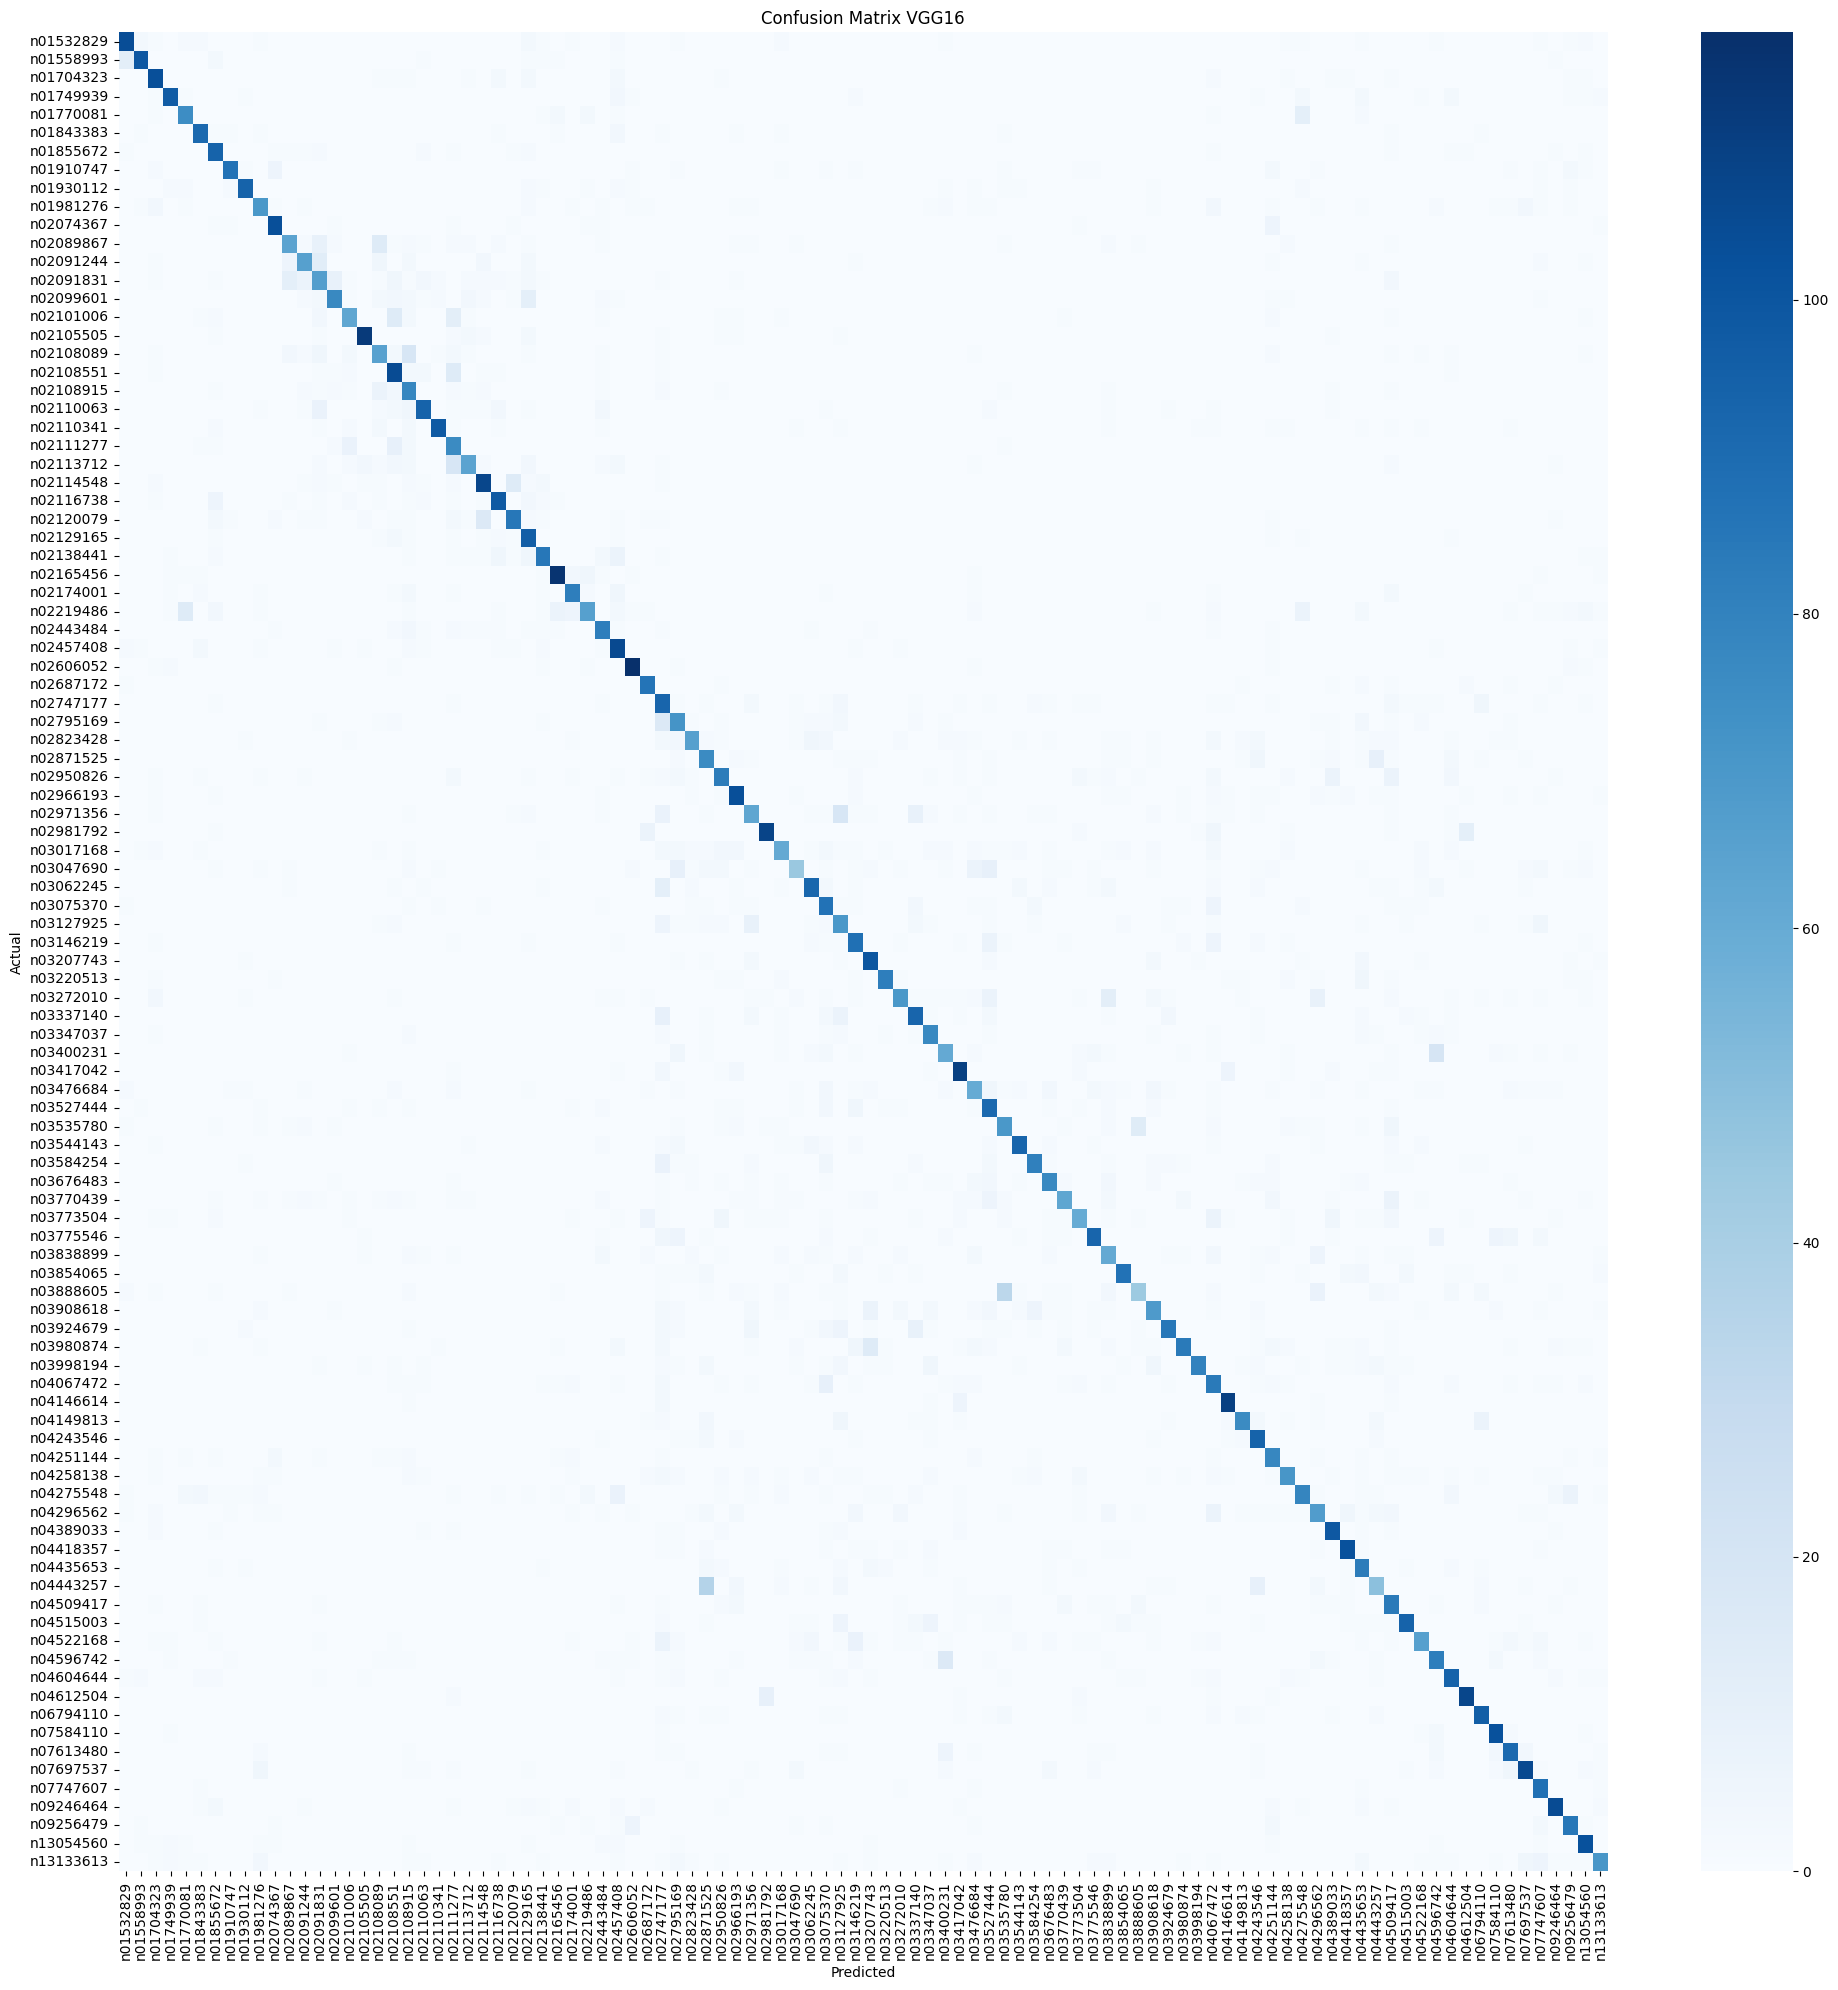

In [62]:
evaluate_performance(model_resnet, val_loader, dict_mapping, device, 'Resnet50')
evaluate_performance(model_vgg, val_loader, dict_mapping, device, 'VGG16')

In [63]:
from google.colab import files
!zip -r model_weights.zip res_net.pth vgg_net.pth
files.download("model_weights.zip")

  adding: res_net.pth (deflated 7%)
  adding: vgg_net.pth (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 2. Wavelet-based Image Compression (Saud)
### 2.1 Implement DWT and thresholding
### 2.2 Compress test images at 10:1, 5:1, 2:1
### 2.3 Visualize original vs. compressed
### 2.4 Analyze performance degradation

In [ ]:
# CODE HERE: Implement wavelet compression

In [ ]:
# CODE HERE: Evaluate model on compressed images

In [ ]:
# CODE HERE:

In [ ]:
# CODE HERE:

## 3. Fine-tuning on Compressed Data (Naif)
### 3.1 Create compressed training set
### 3.2 Fine-tune model on compressed data
### 3.3 Compare performance to original training
### 3.4 Analyze robustness

In [ ]:
# CODE HERE: Fine-tune on compressed training set

In [ ]:
# CODE HERE:

In [ ]:
# CODE HERE:

In [ ]:
# CODE HERE: Evaluate and compare robustness

## 4. Compressed Sensing Experiment (Saud)
### 4.1 Select 20 images from different classes
### 4.2 Apply CS sampling with different rates (0.25, 0.5, 0.75)
### 4.3 Reconstruct using L1-minimization
### 4.4 Evaluate model performance

In [ ]:
# CODE HERE: Compressed sensing acquisition and reconstruction

In [ ]:
# CODE HERE:

In [ ]:
# CODE HERE:

In [ ]:
# CODE HERE: Test on reconstructed images

## 5. Summary and Discussion
### Visualizations & Final Comparison

In [ ]:
# CODE HERE: